In [89]:
# importanto as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import date, time, datetime, timedelta
from prophet import Prophet

#from google.colab import drive # importar módulo do drive e upar base de dados pelo diretório
#drive.mount('drive')

In [258]:
df = pd.read_csv(r'C:\Users\brcalazans\Desktop\Pessoal\FIAP\Aulas\Fase 2\Tech Challenge\dados\Dados Históricos - Ibovespa.csv', sep=',', parse_dates=[0], index_col="Data",dayfirst=True)
df2 = pd.read_csv(r'C:\Users\brcalazans\Desktop\Pessoal\FIAP\Aulas\Fase 2\Tech Challenge\dados\Dados Históricos - Ibovespa (4).csv', sep=',', parse_dates=[0], index_col="Data",dayfirst=True)

In [259]:
ibovespa_diario = pd.concat([df, df2])

In [260]:
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2021-03-11,114.984,112.782,115.127,112.776,"12,09M","1,96%"
2021-03-10,112.776,111.331,112.928,109.999,"12,51M","1,30%"
2021-03-09,111.331,110.611,112.525,109.343,"12,14M","0,65%"
2021-03-08,110.612,115.202,115.202,110.268,"13,70M","-3,98%"
2021-03-05,115.202,112.690,115.504,112.504,"13,25M","2,23%"


In [261]:
ibovespa_diario = ibovespa_diario.sort_index()

In [262]:
ibovespa_diario.loc[ibovespa_diario.index.year > 2019].head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2020-01-02,118.573,115.652,118.573,115.649,"5,16M","2,53%"
2020-01-03,117.707,118.564,118.792,117.341,"6,83M","-0,73%"
2020-01-06,116.878,117.707,117.707,116.269,"6,57M","-0,70%"
2020-01-07,116.662,116.872,117.076,115.965,"4,85M","-0,18%"
2020-01-08,116.247,116.667,117.335,115.693,"5,91M","-0,36%"


In [263]:
ibovespa_diario = ibovespa_diario.loc[ibovespa_diario.index.year > 2020]

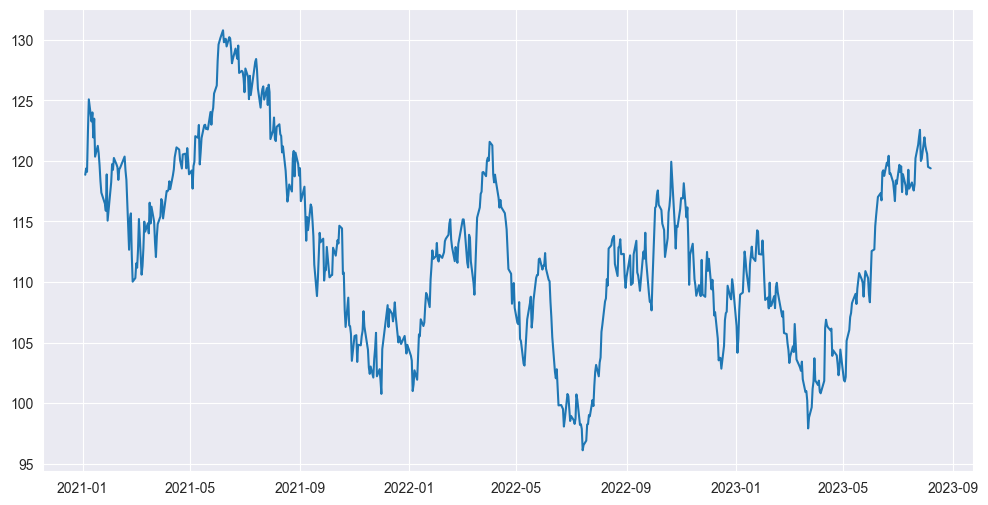

In [264]:
sns.set_style("darkgrid")
ibovespa_diario = ibovespa_diario.sort_index()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(ibovespa_diario.index, ibovespa_diario.Último)
plt.show()

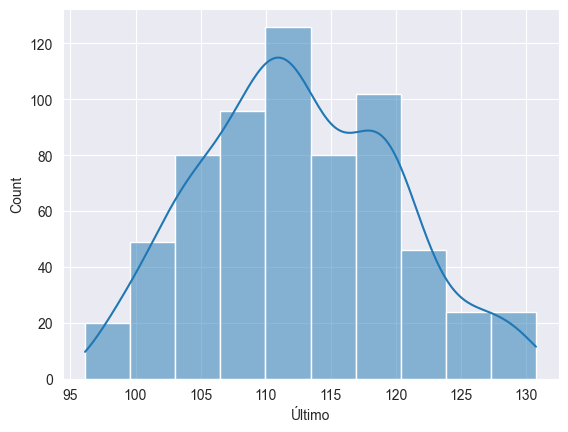

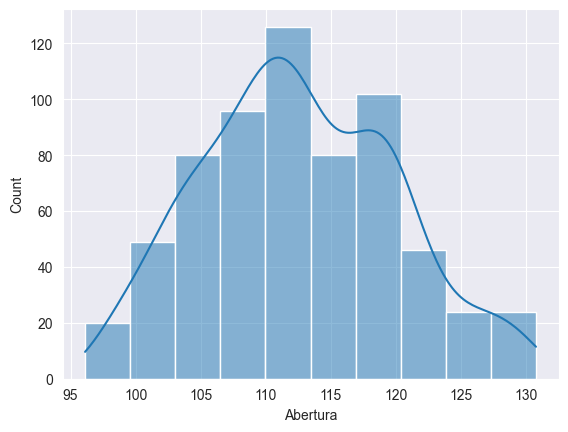

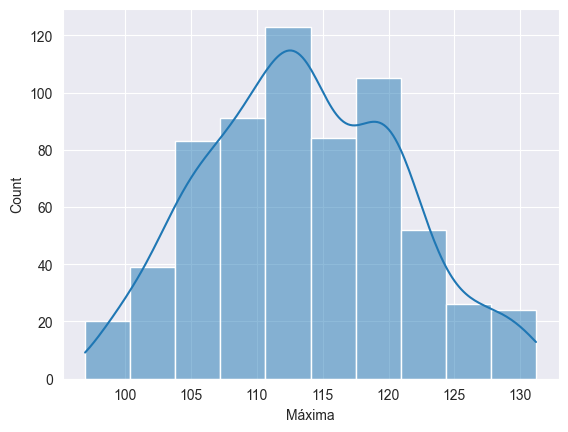

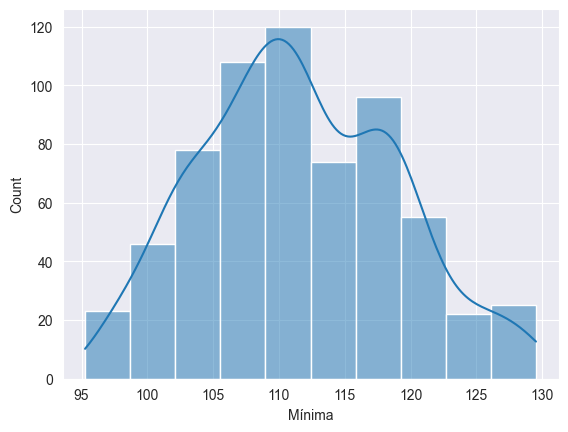

In [265]:
colunas_numericas_preco = ["Último", "Abertura", "Máxima", "Mínima"]
for column in colunas_numericas_preco:
    plt.figure()
    plot = ibovespa_diario[column]
    sns.histplot(plot, bins=10, kde=True)
    plt.show()

In [266]:
ibovespa_diario.shape

(647, 6)

In [267]:
from scipy.stats import norm, shapiro
my_data = ibovespa_diario['Último']
shapiro(my_data)

ShapiroResult(statistic=0.9889400601387024, pvalue=8.471467299386859e-05)

In [268]:
shapiro(my_data).statistic

0.9889400601387024

In [269]:
shapiro(my_data).pvalue

8.471467299386859e-05

In [270]:
# importação de bibliotecas para modelo e análise de series temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation # validação de métricas
from prophet.diagnostics import performance_metrics # validação de métricas
import plotly.graph_objs as go
#import pandas_ta as ta
import math

In [271]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [272]:
dados_decompose = ibovespa_diario[['Último']]
dados_decompose = dados_decompose.dropna()
dados_decompose = dados_decompose.sort_index()

In [273]:
resultados = seasonal_decompose(dados_decompose, period=5, model='multiplicative')

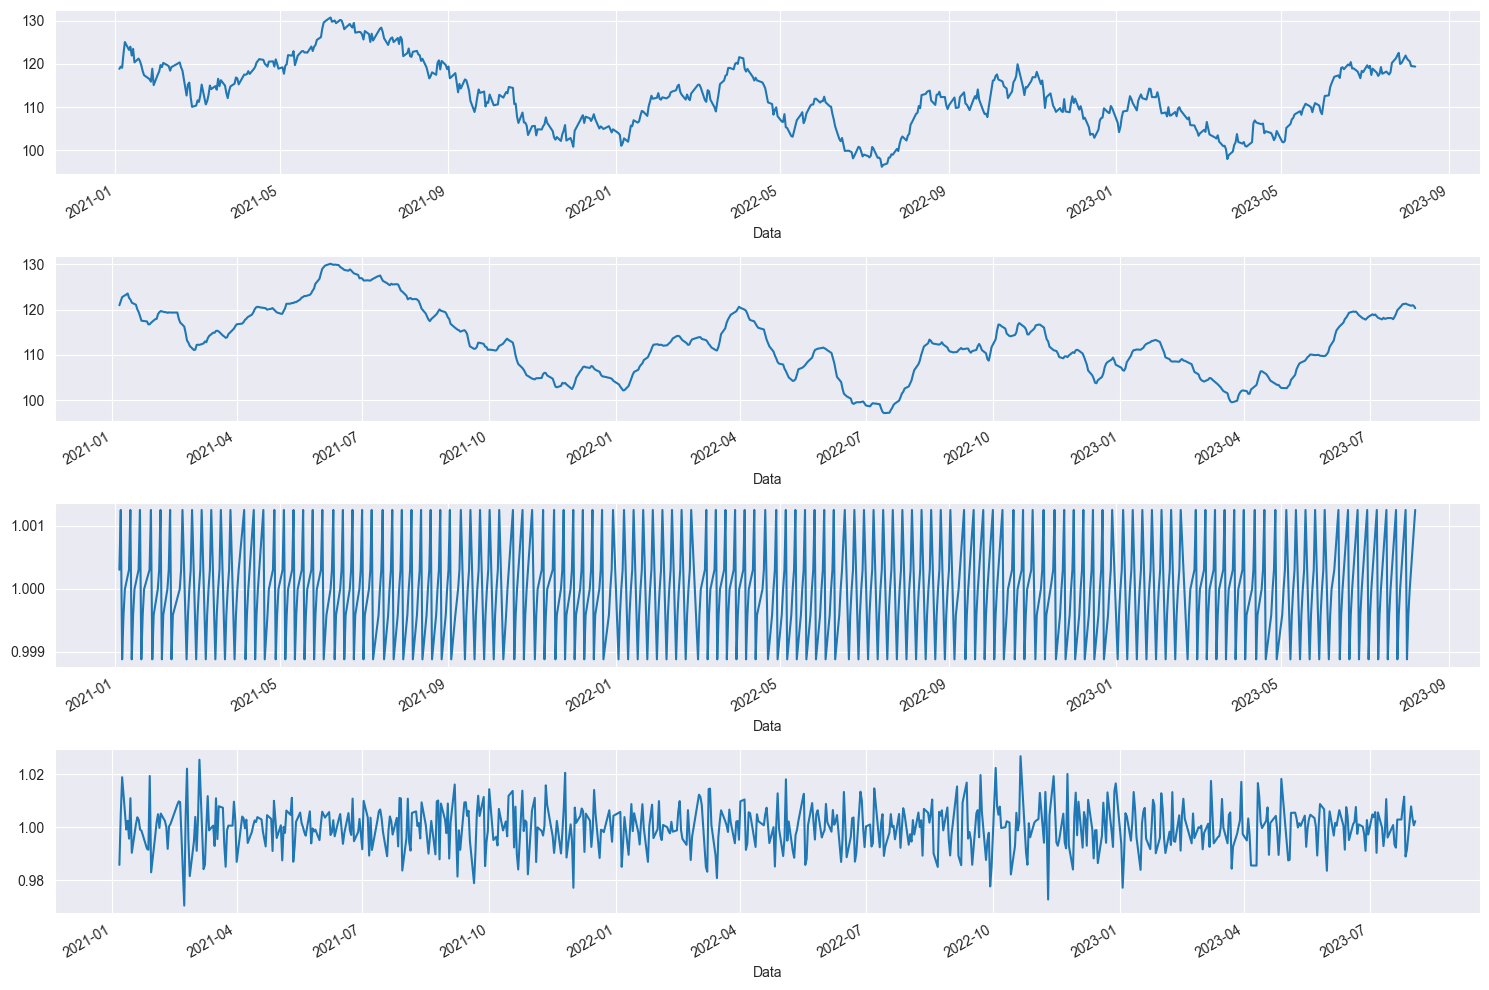

In [274]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultados.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultados.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

In [275]:
resultados.resid.to_frame().mean()

resid    0.999989
dtype: float64

In [276]:
X = ibovespa_diario.Último.values

result_s = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print(f"Valores Críticos:")

for key, value in result_s[4].items():
    print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.451776308935598
P-Value: 0.12765272748205847
Valores Críticos:
	1%: -3.4405132737812596
	5%: -2.8660244429195725
	10%: -2.5691581552588447


In [277]:
result_adfuller = pd.Series(result_s[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P', 'Lags Usados','Número de observações usadas'])
result_adfuller = round(result_adfuller, 4)

for key, value in result_s[4].items():
    result_adfuller["Valores Críticos (%s)"%key] = value.round(4)
result_adfuller

Teste Estatistico Dickey Fuller     -2.4518
Valor-P                              0.1277
Lags Usados                          0.0000
Número de observações usadas       646.0000
Valores Críticos (1%)               -3.4405
Valores Críticos (5%)               -2.8660
Valores Críticos (10%)              -2.5692
dtype: float64

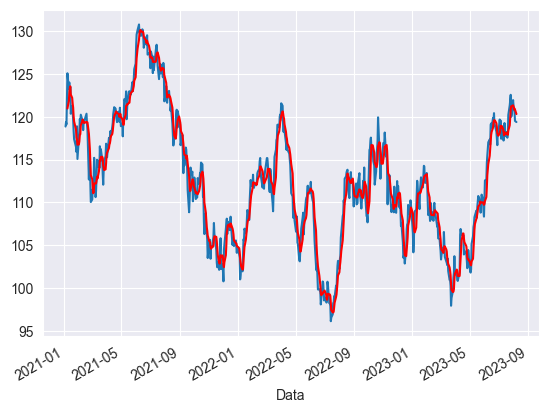

In [22]:
ma = ibovespa_diario['Último'].rolling(5).mean()
f, ax = plt.subplots()
ibovespa_diario['Último'].plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.show()

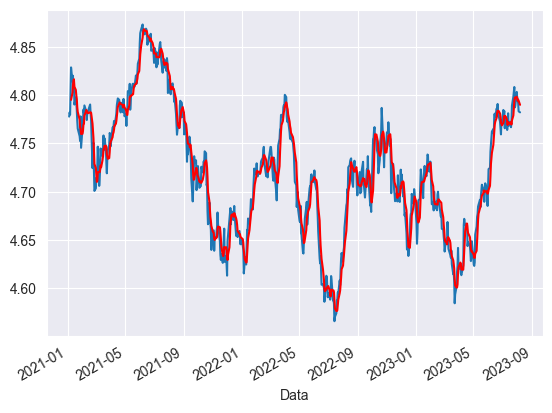

In [23]:
df_log = np.log(ibovespa_diario['Último'])
ma_log = df_log.rolling(5).mean()
f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.show()

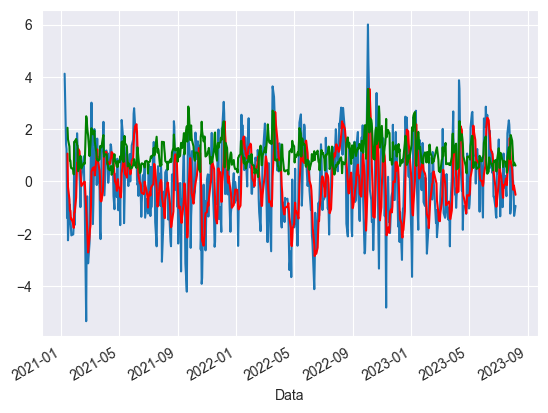

In [283]:
ma_log = ibovespa_diario['Último'].rolling(5).mean()
df_s = (ibovespa_diario['Último'] - ma_log).dropna()
ma_s = df_s.rolling(5).mean()
std  = df_s.rolling(5).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.show()

In [284]:
X_s = df_s.values

result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print(f"Valores Críticos:")

for key, value in result_s[4].items():
    print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -9.743789756722526
P-Value: 8.359738161689226e-17
Valores Críticos:
	1%: -3.440641231176813
	5%: -2.8660808067889976
	10%: -2.569188186240308


Teste ADF
Teste Estatístico: -10.221830376095031
P-Value: 5.3000067456366444e-18
Valores Críticos:
	1%: -3.440856177517568
	5%: -2.86617548304384
	10%: -2.56923863104


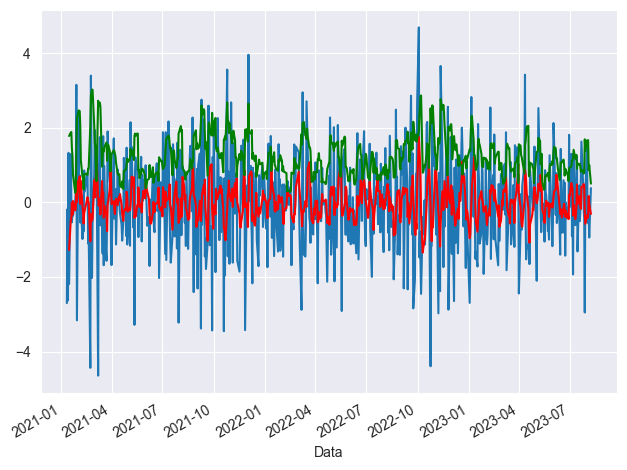

In [285]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(5).mean()
std_diff = df_diff.rolling(5).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

X_diff = df_diff.dropna().values

result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print(f"Valores Críticos:")

for key, value in result_diff[4].items():
    print(f"\t{key}: {value}")

In [286]:
dados_decompose = df_diff.to_frame()
dados_decompose = dados_decompose.dropna()
dados_decompose = dados_decompose.sort_index()

In [287]:
resultados = seasonal_decompose(dados_decompose, period=5)

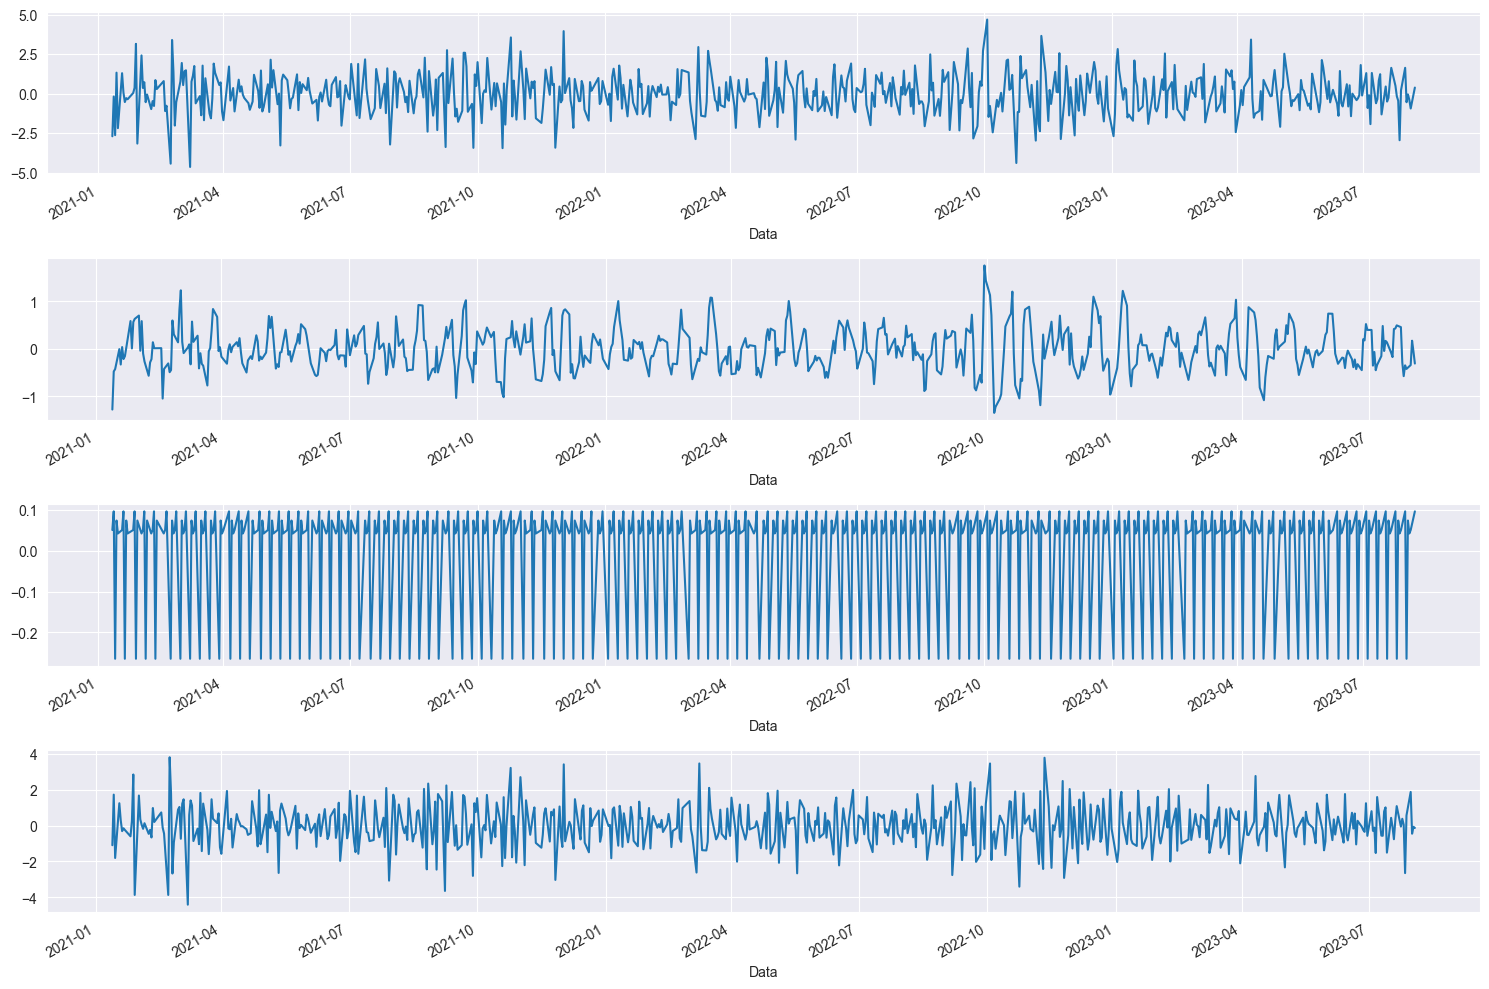

In [288]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultados.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultados.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

In [289]:
resultados.resid.to_frame().mean()

resid    0.000168
dtype: float64

In [290]:
lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

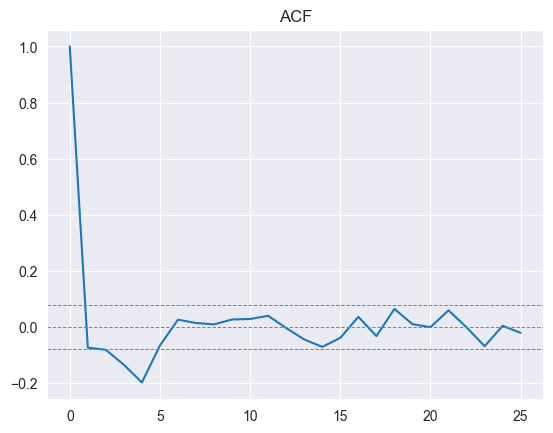

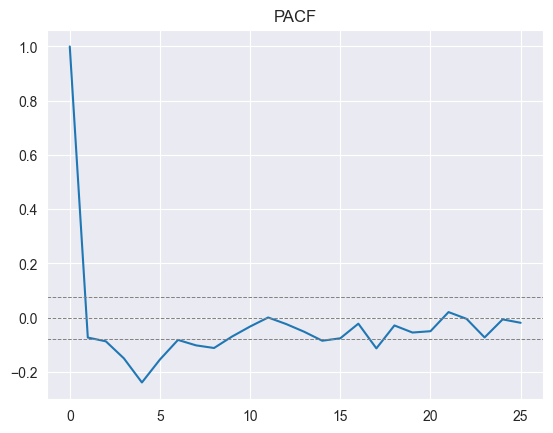

In [291]:
plt.plot(lag_acf)

plt.axhline(y=-1.96/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=0/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=1.96/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y=-1.96/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=0/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=1.96/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)

plt.title("PACF")
plt.show()

In [292]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

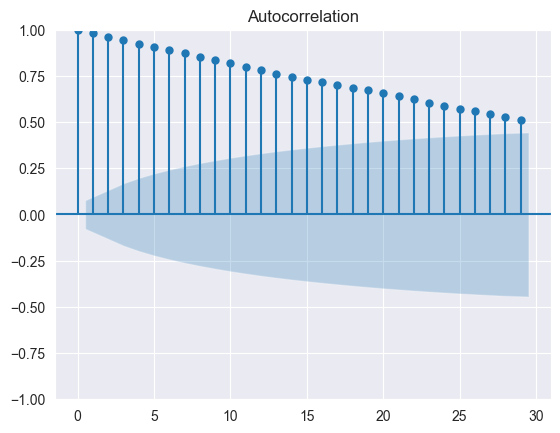

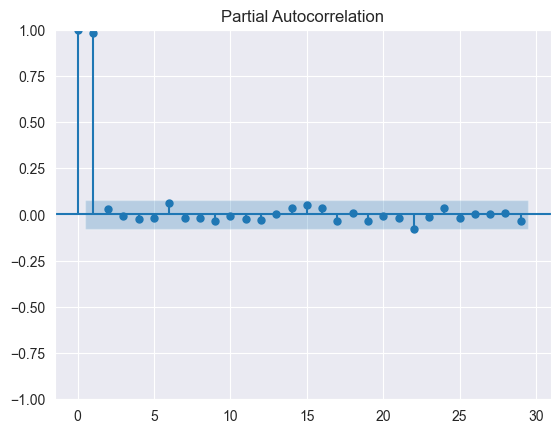

In [293]:
plot_acf(ibovespa_diario['Último'])
plot_pacf(ibovespa_diario['Último'])
plt.show()

In [294]:
def wmape(y_true, y_pred):
    return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [295]:
df_x = df_diff.to_frame().reset_index().rename(columns={"Data": "ds", "Último": "y"})
df_x['unique_id']  = 'Ibovespa'
treino = df_x.loc[(df_x['ds'].dt.year <=2023) & (df_x['ds'].dt.month < 8)]
treino = treino.dropna()
valid = df_x.loc[(df_x['ds'].dt.year >= 2023) & (df_x['ds'].dt.month >= 8)]
h = valid['ds'].nunique()

In [296]:
valid

,ds,y,unique_id
638,2023-08-01,-0.5430,Ibovespa
639,2023-08-02,-0.0488,Ibovespa
640,2023-08-03,-0.3922,Ibovespa
641,2023-08-04,-0.9422,Ibovespa
642,2023-08-07,0.3846,Ibovespa


In [297]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, AutoETS

In [331]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=12)], freq='B', n_jobs=-1)
model_s.fit(treino)

forecast_dfs = model_s.predict(h=h, level=[5])
forecast_dfs = forecast_dfs.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_dfs = forecast_dfs.dropna()
wmape2 = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f"WMAPE: {wmape2:.2%}")

WMAPE: 105.70%


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


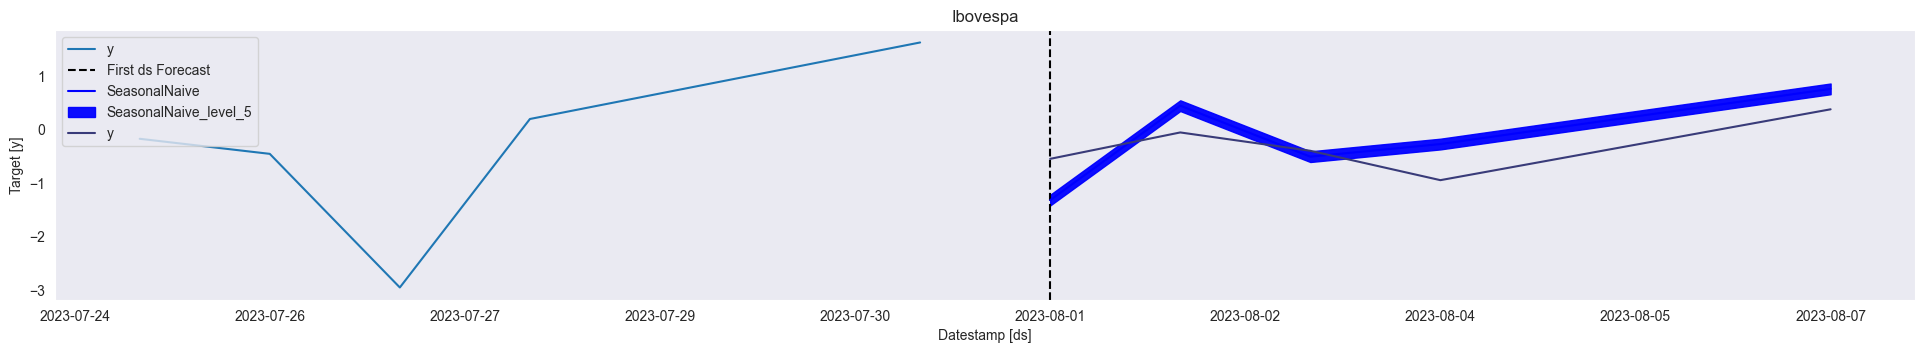

In [332]:
model_s.plot(treino, forecast_dfs, level=[5], unique_ids=['Ibovespa'], engine="matplotlib", max_insample_length=5)

In [333]:
forecast_dfs

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-5,SeasonalNaive-hi-5,y
0,Ibovespa,2023-08-01,-1.3156,-1.415724,-1.215476,-0.5430
1,Ibovespa,2023-08-02,0.4526,0.352476,0.552724,-0.0488
2,Ibovespa,2023-08-03,-0.5022,-0.602324,-0.402076,-0.3922
3,Ibovespa,2023-08-04,-0.2662,-0.366324,-0.166076,-0.9422
4,Ibovespa,2023-08-07,0.7672,0.667076,0.867324,0.3846


In [350]:
model_a = StatsForecast(models=[AutoARIMA(season_length=3)], freq='C',n_jobs=-1)
model_a.fit(treino)

forecast_dfa = model_a.predict(h=h, level=[5])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_dfa = forecast_dfa.dropna()
wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f"WMAPE: {wmape4:.2%}")

WMAPE: 82.50%


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


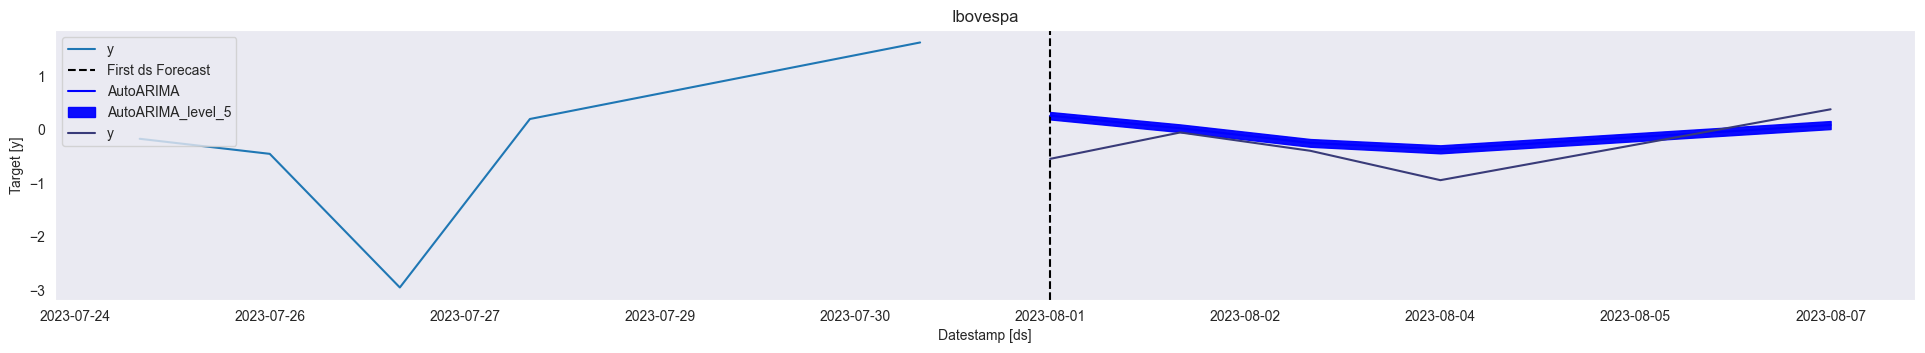

In [351]:
model_a.plot(treino, forecast_dfa, level=[5], unique_ids=['Ibovespa'], engine="matplotlib", max_insample_length=5)

In [257]:
forecast_dfa

,unique_id,ds,AutoARIMA,AutoARIMA-lo-5,AutoARIMA-hi-5,y
0,Ibovespa,2023-08-01,0.002554,0.001939,0.003170,-0.004466
1,Ibovespa,2023-08-02,-0.000053,-0.000680,0.000574,-0.000418
2,Ibovespa,2023-08-03,-0.001879,-0.002522,-0.001237,-0.003252
3,Ibovespa,2023-08-04,-0.002983,-0.003650,-0.002317,-0.007847
4,Ibovespa,2023-08-07,0.000693,0.000025,0.001361,0.003177


In [352]:
m = Prophet()
m.fit(treino)

12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing


In [353]:
future = m.make_future_dataframe(periods=5)
future.tail()

,ds
428,2023-08-01
429,2023-08-02
430,2023-08-03
431,2023-08-04
432,2023-08-05


In [354]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
428,2023-08-01,-0.382660,-1.953772,1.091503
429,2023-08-02,-0.276966,-1.759934,1.256854
430,2023-08-03,-0.554580,-2.091053,1.009024
431,2023-08-04,-0.845553,-2.350647,0.662900
432,2023-08-05,-1.978890,-3.479809,-0.507954


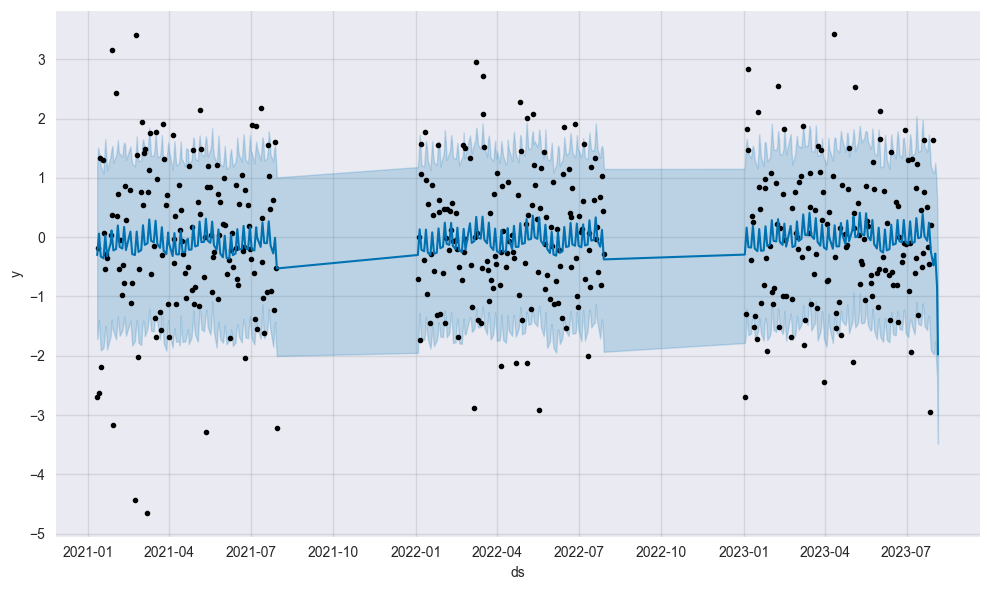

In [355]:
fig1 = m.plot(forecast)

In [356]:
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2021-03-11,114.984,112.782,115.127,112.776,"12,09M","1,96%"
2021-03-10,112.776,111.331,112.928,109.999,"12,51M","1,30%"
2021-03-09,111.331,110.611,112.525,109.343,"12,14M","0,65%"
2021-03-08,110.612,115.202,115.202,110.268,"13,70M","-3,98%"
2021-03-05,115.202,112.690,115.504,112.504,"13,25M","2,23%"
...,...,...,...,...,...,...
2001-01-04,16.675,16.597,16.933,16.587,"331,23M","0,46%"
2001-01-03,16.599,15.425,16.599,15.251,"381,20M","7,61%"
2001-01-02,15.425,15.242,15.621,15.174,"230,63M","1,09%"


In [357]:
df_prophet =  df_s.to_frame().reset_index()
df_prophet = df_prophet.rename(columns={"Data":"ds", "Último": "y"})
forecast = forecast.merge(df_prophet[["ds", "y"]], on=['ds'], how='left')
forecast = forecast.dropna()

In [358]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
427,2023-07-31,-0.888685,-1.970682,1.083560,-0.888685,-0.888685,0.412411,0.412411,0.412411,0.176655,0.176655,0.176655,0.235756,0.235756,0.235756,0.0,0.0,0.0,-0.476273,0.6054
428,2023-08-01,-0.888534,-1.953772,1.091503,-0.888534,-0.888534,0.505875,0.505875,0.505875,0.359351,0.359351,0.359351,0.146524,0.146524,0.146524,0.0,0.0,0.0,-0.382660,0.0624
429,2023-08-02,-0.888384,-1.759934,1.256854,-0.888384,-0.888384,0.611418,0.611418,0.611418,0.559728,0.559728,0.559728,0.051690,0.051690,0.051690,0.0,0.0,0.0,-0.276966,0.0136
430,2023-08-03,-0.888234,-2.091053,1.009024,-0.888234,-0.888234,0.333654,0.333654,0.333654,0.381399,0.381399,0.381399,-0.047745,-0.047745,-0.047745,0.0,0.0,0.0,-0.554580,-0.3786
431,2023-08-04,-0.888084,-2.350647,0.662900,-0.888084,-0.888084,0.042531,0.042531,0.042531,0.193183,0.193183,0.193183,-0.150652,-0.150652,-0.150652,0.0,0.0,0.0,-0.845553,-1.3208


In [360]:
print(f"WMAPE: {wmape(forecast[['y']].tail().values, forecast[['yhat']].tail().values):.2%}") 

WMAPE: 103.68%


In [143]:
treino

,ds,y,unique_id
0,2021-01-08,0.033678,Ibovespa
1,2021-01-11,0.011734,Ibovespa
2,2021-01-12,0.010147,Ibovespa
3,2021-01-13,-0.011349,Ibovespa
4,2021-01-14,-0.000515,Ibovespa
...,...,...,...
633,2023-07-25,0.018033,Ibovespa
634,2023-07-26,0.014203,Ibovespa
635,2023-07-27,-0.010193,Ibovespa
636,2023-07-28,-0.008503,Ibovespa


In [239]:
treino

,ds,y,unique_id
0,2021-01-08,NaN,Ibovespa
1,2021-01-11,-0.021944,Ibovespa
2,2021-01-12,-0.001587,Ibovespa
3,2021-01-13,-0.021495,Ibovespa
4,2021-01-14,0.010834,Ibovespa
...,...,...,...
633,2023-07-25,-0.001476,Ibovespa
634,2023-07-26,-0.003830,Ibovespa
635,2023-07-27,-0.024396,Ibovespa
636,2023-07-28,0.001690,Ibovespa


In [249]:
#autoETS

model_a = StatsForecast(models=[AutoETS(season_length=3, model='ZMZ')], freq='B',n_jobs=-1)
model_a.fit(treino)

forecast_dfa = model_a.predict(h=h, level=[5])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_dfa = forecast_dfa.dropna()
wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoETS'].values)
print(f"WMAPE: {wmape4:.2%}")

C:\Users\brcalazans\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\ets.py:1039: RuntimeWarning: overflow encountered in square
  sigma2 = np.sum(e**2) / (ny - np_ - 1)


Exception: no model able to be fitted

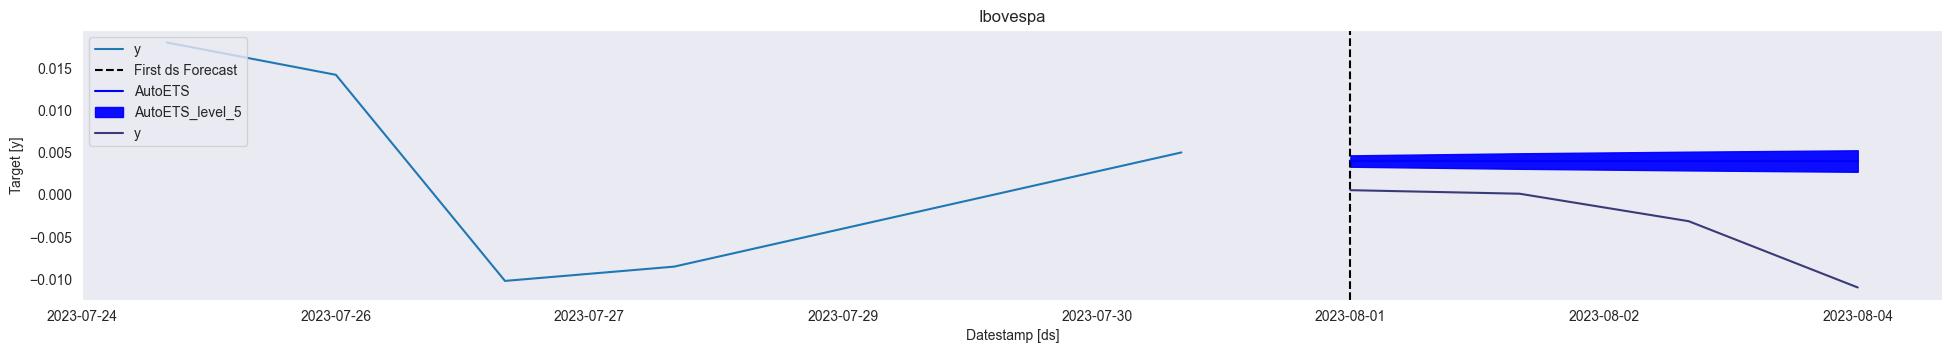

In [149]:
model_a.plot(treino, forecast_dfa, level=[5], unique_ids=['Ibovespa'], engine="matplotlib", max_insample_length=5)

In [132]:
a = wmape(forecast_dfa['y'].values[0:4], forecast_dfa['AutoETS'].values[0:4])

In [133]:
print(f"WMAPE: {a:.2%}")

WMAPE: 199.07%


In [148]:
forecast_dfa

,unique_id,ds,AutoETS,AutoETS-lo-5,AutoETS-hi-5,y
0,Ibovespa,2023-08-01,0.003997,0.003323,0.004671,0.000548
1,Ibovespa,2023-08-02,0.003997,0.003079,0.004915,0.000130
2,Ibovespa,2023-08-03,0.003997,0.002888,0.005106,-0.003122
3,Ibovespa,2023-08-04,0.003997,0.002725,0.005269,-0.010969
